<a href="https://colab.research.google.com/github/Jaimemorillo/ShouldIwatchThisMovie/blob/master/sentence_embedding_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import pandas as pd
import tensorflow as tf
import time
import numpy as np
import tensorflow_hub as hub

print(tf.__version__)

W0320 19:17:21.352739 139854951438208 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


1.13.1


In [0]:
data = pd.read_csv("gdrive/My Drive/TFG/tmdb_spanish_overview.csv",sep='#',lineterminator='\n')

In [5]:
data = data[~pd.isna(data.overview)]
len(data)

4406

In [6]:
up = 7.3
under = 5

like = data[data.vote_average >= up]
dislike = data[data.vote_average <= under]
neutral = data.loc[(data['vote_average'] > under) & (data['vote_average'] < up )]

print(len(like))
print(len(dislike))
print(len(neutral))

535
442
3429


In [7]:
like.loc[:,'like'] = 1
neutral['like'] = neutral.vote_average.apply(lambda x: 0 if x < 5.9 else 1)
dislike.loc[:,'like'] = 0

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://

In [0]:
data = like.append(dislike)

In [0]:
import string

stop_words = pd.read_csv("gdrive/My Drive/TFG/stopwords-es.txt",header=None)
stop_words = stop_words[0].tolist()

def normalize(s):
    replacements = (
        ("á", "a"),
        ("é", "e"),
        ("í", "i"),
        ("ó", "o"),
        ("ú", "u"),
    )
    for a, b in replacements:
        s = s.replace(a, b).replace(a.upper(), b.upper())
    return s

def clean_overview(x):
    x = normalize(x.lower())
    """x = x.replace('.', ' <PERIOD>')
    x = x.replace(',', ' <COMMA>')
    x = x.replace(';', ' <SEMICOLON>')"""
    x = x.translate(str.maketrans('','',string.punctuation))
    x = x.translate(str.maketrans('','','1234567890ªº'))
    return x
  

In [0]:
data['overview']=data['overview'].apply(lambda x: clean_overview(str(x)))

In [0]:
from sklearn.model_selection import train_test_split

overviews = data['overview'].values
y = data['like'].values

overviews_netutral =  neutral['overview'].values
y_netural = neutral['like'].values

overviews_train, overviews_test, y_train, y_test = train_test_split(overviews, y, test_size=0.1, random_state=777, stratify=y)

In [0]:
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping

def precision(y_true, y_pred):
    """Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


es = EarlyStopping(monitor='val_loss',
                   min_delta=0,
                   patience=2,
                   verbose=0, mode='auto')

In [15]:
from sklearn.utils import class_weight


class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

class_weights

array([1.10427136, 0.91372141])

In [17]:
# Model 3

from tensorflow.keras import Model
from tensorflow.keras import layers
import tensorflow_hub as hub
from tensorflow.keras import optimizers

module_url = "https://tfhub.dev/google/nnlm-es-dim128-with-normalization/1"
embed = hub.Module(module_url)

with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  sess.run(tf.tables_initializer())


def UniversalEmbedding(x):
  return embed(tf.squeeze(tf.cast(x, tf.string)), 
  signature="default", as_dict=True)["default"]
    
input_text = layers.Input(shape=(1,), dtype=tf.string)
embedding = layers.Lambda(UniversalEmbedding,output_shape=(128,))(input_text)
dense = layers.Dense(128, activation='relu')(embedding)
pred = layers.Dense(1, activation='sigmoid')(dense)
model = Model(inputs=[input_text], outputs=pred)
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(0.0003), metrics=['accuracy'])  
 
model.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0320 19:30:03.613175 139854951438208 saver.py:1483] Saver not created because there are no variables in the graph to restore


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 16,641
Trainable params: 16,641
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Model 3

with tf.Session() as session:
  K.set_session(session)
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  history = model.fit(overviews_train, y_train,
                    epochs=500,
                    verbose=True,
                    validation_data=(overviews_test, y_test),
                    batch_size=128, callbacks=[es], class_weight = class_weights)

Train on 879 samples, validate on 98 samples
Instructions for updating:
Use tf.cast instead.


W0320 19:42:04.820112 139854951438208 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Epoch 1/500
879/879 [==============================] - 1s 1ms/sample - loss: 0.6909 - acc: 0.5301 - val_loss: 0.6838 - val_acc: 0.5510
Epoch 2/500
879/879 [==============================] - 0s 103us/sample - loss: 0.6860 - acc: 0.5461 - val_loss: 0.6804 - val_acc: 0.5408
Epoch 3/500
879/879 [==============================] - 0s 104us/sample - loss: 0.6827 - acc: 0.5495 - val_loss: 0.6780 - val_acc: 0.5510
Epoch 4/500
879/879 [==============================] - 0s 112us/sample - loss: 0.6796 - acc: 0.5484 - val_loss: 0.6759 - val_acc: 0.5510
Epoch 5/500
879/879 [==============================] - 0s 108us/sample - loss: 0.6769 - acc: 0.5495 - val_loss: 0.6738 - val_acc: 0.5510
Epoch 6/500
879/879 [==============================] - 0s 107us/sample - loss: 0.6739 - acc: 0.5518 - val_loss: 0.6717 - val_acc: 0.5510
Epoch 7/500
879/879 [==============================] - 0s 117us/sample - loss: 0.6710 - acc: 0.5575 - val_loss: 0.6698 - val_acc: 0.5510
Epoch 8/500
879/879 [======================

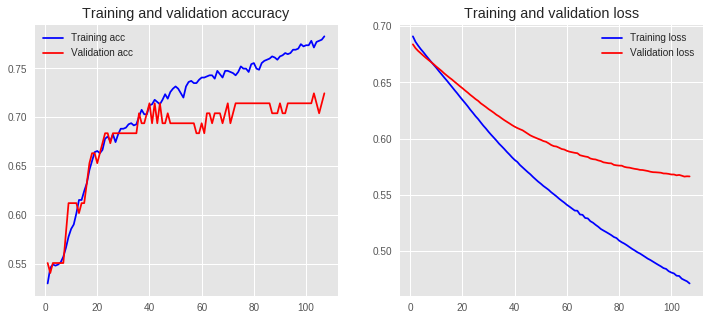

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
plot_history(history)